## Explicació del dataset: Bike Sharing in Washington D.C. Dataset

El nostre dataset consisteix en el nombre de persones que han llogat una bicicleta en Washington durant els anys 2011 i 2012. Aquest dataset conté els atributs següents:


* instant: índex de la fila
* dteday: la data del dia corresponent
* season: l'estació de l'any en la que ens trobem (1: primavera, 2: estiu, 3: tardor, 4: hivern)
* yr: l'any en el que estem (0: 2011, 1: 2012)
* mnth: el mes en el que estem (número de l'1 al 12)
* holiday: un boleà que indica si el dia es festiu o no
* weekday: un nombre que indica el dia de la setmana en el que ens trobem (del 0 al 6)
* workingday: un boleà que indica si el dia és laborable o no
* weathersit: un total de 4 diferents tipus de clima (1: cel clar, 2: cel nublat, 3: pluja lleu, 4: tempesta)
* temp: temperatura del dia corresponent
* atemp: sensació de temperatura del dia corresponent
* hum: el grau d'humitat del dia corresponent
* windspeed: la velocitat del vent del dia corresponent
* casual: nombre de bicicletes llogades de manera casual
* registered: nombre de bicicletes llogades de manera regular
* cnt: nombre total de bicicletes llogades

El nostre objectiu és trobar el nombre de bicicletes que es lloguen en días laborables al llarg dels anys 2011 i 2012.

# Imports

In [1]:
from matplotlib import pyplot as plt
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import preprocessing

import math
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy.stats

%matplotlib notebook

## Descarrega del dataset

In [2]:
# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('C:/Users/marcb/Desktop/APC/day.csv')
data = dataset.values

dimensio_x = data[:, :15]
dimensio_y = data[:, 15]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", dimensio_x.shape)
print("Dimensionalitat de l'atribut Y", dimensio_y.shape)

Dimensionalitat de la BBDD: (731, 16)
Dimensionalitat de les entrades X (731, 15)
Dimensionalitat de l'atribut Y (731,)


#### Imprimim el dataset per veure la forma que té

In [3]:
print(dataset)

     instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0          1  2011-01-01       1   0     1        0        6           0   
1          2  2011-01-02       1   0     1        0        0           0   
2          3  2011-01-03       1   0     1        0        1           1   
3          4  2011-01-04       1   0     1        0        2           1   
4          5  2011-01-05       1   0     1        0        3           1   
..       ...         ...     ...  ..   ...      ...      ...         ...   
726      727  2012-12-27       1   1    12        0        4           1   
727      728  2012-12-28       1   1    12        0        5           1   
728      729  2012-12-29       1   1    12        0        6           0   
729      730  2012-12-30       1   1    12        0        0           0   
730      731  2012-12-31       1   1    12        0        1           1   

     weathersit  temp  atemp   hum  windspeed  casual  registered   cnt  
0            

# Adaptació del dataset amb les seves justificacions

El nostre objectiu és estudiar el nombre de bicicletes que es lloguen en dies laborables, és per això que cal fer una reducció del dataset perquè tenim moltes columnes amb informació irrellevant per la nostra investigació. A continuació justificarem perquè hem eliminat les columnes següents: 

* dteday: és una variable string, la qual cosa ens dificulta la nostra investigació. Nosaltres només necessitem saber si el dia és laborable o si no ho és, per tant, ens és irrellevant.
* season, yr, mnth, weekday: com que només volem estudiar si el dia és laborable o no ho és, no necessitem saber ni l'estació de l'any, ni l'any ni el dia de la setmana en el que ens trobem.
* holiday: de tota les dades que hi ha en aquesta columna, només el 2.87% és true. Per tant, per falta d'informació, hem decidit prescindir d'aquesta variable i centrar-nos únicament en workingday per determinar si el dia és laborable o no ho és.
* casual, registered: ens hem centrat en el nombre total de bicicletes (cnt) directament

Per tant, eliminem les columnes anteriors de la següent manera:

In [4]:
dataset.drop(['holiday'], axis=1)
dataset = dataset.drop(['holiday'], axis=1)

dataset.drop(['instant'], axis=1)
dataset = dataset.drop(['instant'], axis=1)

dataset.drop(['dteday'], axis=1)
dataset = dataset.drop(['dteday'], axis=1)

dataset.drop(['season'], axis=1)
dataset = dataset.drop(['season'], axis=1)

dataset.drop(['yr'], axis=1)
dataset = dataset.drop(['yr'], axis=1)

dataset.drop(['mnth'], axis=1)
dataset = dataset.drop(['mnth'], axis=1)

dataset.drop(['weekday'], axis=1)
dataset = dataset.drop(['weekday'], axis=1)

dataset.drop(['casual'], axis=1)
dataset = dataset.drop(['casual'], axis=1)

dataset.drop(['registered'], axis=1)
dataset = dataset.drop(['registered'], axis=1)

print(dataset)

     workingday  weathersit  temp  atemp   hum  windspeed   cnt
0             0           2 0.344  0.364 0.806      0.160   985
1             0           2 0.363  0.354 0.696      0.249   801
2             1           1 0.196  0.189 0.437      0.248  1349
3             1           1 0.200  0.212 0.590      0.160  1562
4             1           1 0.227  0.229 0.437      0.187  1600
..          ...         ...   ...    ...   ...        ...   ...
726           1           2 0.254  0.227 0.653      0.350  2114
727           1           2 0.253  0.255 0.590      0.155  3095
728           0           2 0.253  0.242 0.753      0.124  1341
729           0           1 0.256  0.232 0.483      0.351  1796
730           1           2 0.216  0.223 0.578      0.155  2729

[731 rows x 7 columns]


Ara tenim un problema amb weathersit. Es tracta d'uns valors arbitraris entre l'1 i el 4 que determinen el clima. Hem dedicit formar 4 variables boleanes diferents a partir d'aquesta. Aquest procès s'anomena "one-hot encoding". Ens interessa que cnt estigui a la dreta de tot, per tant creem una altra variable per col·locar-la després d'aquestes noves columnes.

In [5]:
#Inicialitzem les noves columnes a False
dataset['Clear'] = [0]*731 #nombre total de columnes que tenim
dataset['Mist&Cloudy'] = [0]*731
dataset['LightRain'] = [0]*731
dataset['IcePallets'] = [0]*731
dataset['cnt2'] = dataset['cnt']

#Assignem els valors True a les files corresponents
for i in range(len(dataset['weathersit'])):
    
    if dataset['weathersit'][i]==1:
        dataset['Clear'][i] = 1
    
    if dataset['weathersit'][i]==2:
        dataset['Mist&Cloudy'][i] = 1
        
    if dataset['weathersit'][i]==3:
        dataset['LightRain'][i] = 1
        
    if dataset['weathersit'][i]==4:
        dataset['IcePallets'][i] = 1

#Eliminem la columna que donava problemes
dataset.drop(['weathersit'], axis=1)
dataset = dataset.drop(['weathersit'], axis=1)

#Eliminem cnt per poder tenir la seva copia a l'ultima columna i així tenir més fàcil el seu accés
dataset.drop(['cnt'], axis=1)
dataset = dataset.drop(['cnt'], axis=1)

print(dataset)

C:\Users\marcb\AppData\Local\Temp\ipykernel_22388\3326799516.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Mist&Cloudy'][i] = 1
C:\Users\marcb\AppData\Local\Temp\ipykernel_22388\3326799516.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Clear'][i] = 1
C:\Users\marcb\AppData\Local\Temp\ipykernel_22388\3326799516.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['LightRain'][i] = 1


     workingday  temp  atemp   hum  windspeed  Clear  Mist&Cloudy  LightRain  \
0             0 0.344  0.364 0.806      0.160      0            1          0   
1             0 0.363  0.354 0.696      0.249      0            1          0   
2             1 0.196  0.189 0.437      0.248      1            0          0   
3             1 0.200  0.212 0.590      0.160      1            0          0   
4             1 0.227  0.229 0.437      0.187      1            0          0   
..          ...   ...    ...   ...        ...    ...          ...        ...   
726           1 0.254  0.227 0.653      0.350      0            1          0   
727           1 0.253  0.255 0.590      0.155      0            1          0   
728           0 0.253  0.242 0.753      0.124      0            1          0   
729           0 0.256  0.232 0.483      0.351      1            0          0   
730           1 0.216  0.223 0.578      0.155      0            1          0   

     IcePallets  cnt2  
0             0

De les dades boleanes que tenim, anem a estudiar la proporció de valors True (1) de cada variable:

In [6]:
ratio_workingday = dataset['workingday'].sum() / 731
ratio_Clear = dataset['Clear'].sum() / 731
ratio_MistCloudy = dataset['Mist&Cloudy'].sum() / 731 
ratio_LightRain = dataset['LightRain'].sum() / 731 
ratio_IcePallets = dataset['IcePallets'].sum() / 731

print("Ratio de la variable workingday", ratio_workingday)
print("Ratio de la variable Clear", ratio_Clear)
print("Ratio de la variable Mist&Cloudy", ratio_MistCloudy)
print("Ratio de la variable LightRain", ratio_LightRain)
print("Ratio de la variable IcePallets", ratio_IcePallets)

Ratio de la variable workingday 0.6839945280437757
Ratio de la variable Clear 0.6333789329685362
Ratio de la variable Mist&Cloudy 0.3378932968536252
Ratio de la variable LightRain 0.028727770177838577
Ratio de la variable IcePallets 0.0


Veiem com tant LightRain i Icepallets tenen una ratio de valors true inferior al 3%. És per això que hem decidit eliminar aquestes dues columnes.

In [7]:
dataset.drop(['LightRain'], axis=1)
dataset = dataset.drop(['LightRain'], axis=1)

dataset.drop(['IcePallets'], axis=1)
dataset = dataset.drop(['IcePallets'], axis=1)

print(dataset)

     workingday  temp  atemp   hum  windspeed  Clear  Mist&Cloudy  cnt2
0             0 0.344  0.364 0.806      0.160      0            1   985
1             0 0.363  0.354 0.696      0.249      0            1   801
2             1 0.196  0.189 0.437      0.248      1            0  1349
3             1 0.200  0.212 0.590      0.160      1            0  1562
4             1 0.227  0.229 0.437      0.187      1            0  1600
..          ...   ...    ...   ...        ...    ...          ...   ...
726           1 0.254  0.227 0.653      0.350      0            1  2114
727           1 0.253  0.255 0.590      0.155      0            1  3095
728           0 0.253  0.242 0.753      0.124      0            1  1341
729           0 0.256  0.232 0.483      0.351      1            0  1796
730           1 0.216  0.223 0.578      0.155      0            1  2729

[731 rows x 8 columns]


I aquest és el dataset definitiu amb el que treballarem i del que extreurem la resposta de la nostra investigació. Si recalculem les seves dimensions, tenim el següent:

In [8]:
data = dataset.values

x = data[:, :7]
y = data[:, 7]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Dimensionalitat de la BBDD: (731, 8)
Dimensionalitat de les entrades X (731, 7)
Dimensionalitat de l'atribut Y (731,)


El tipus de cada atribut és:

In [9]:
print("Workingday : ", type(dataset['workingday'][0]))
print("Temp : ",type(dataset['temp'][0]))
print("Atemp : ", type(dataset['atemp'][0]))
print("Hum : ", type(dataset['hum'][0]))
print("Windspeed : ", type(dataset['windspeed'][0]))
print("Clear : ", type(dataset['Clear'][0]))
print("Mist&Cloudy : ", type(dataset['Mist&Cloudy'][0]))
print("Cnt : ", type(dataset['cnt2'][0]))

Workingday :  <class 'numpy.int64'>
Temp :  <class 'numpy.float64'>
Atemp :  <class 'numpy.float64'>
Hum :  <class 'numpy.float64'>
Windspeed :  <class 'numpy.float64'>
Clear :  <class 'numpy.int64'>
Mist&Cloudy :  <class 'numpy.int64'>
Cnt :  <class 'numpy.int64'>


Cal tenir en compte que els valors booleans són ints perquè només poden ser o 0 o 1, que són int.

Ara estudiarem la distribució de les dades construïnt diferents histogrames de les dades anteriors. 

<IPython.core.display.Javascript object>


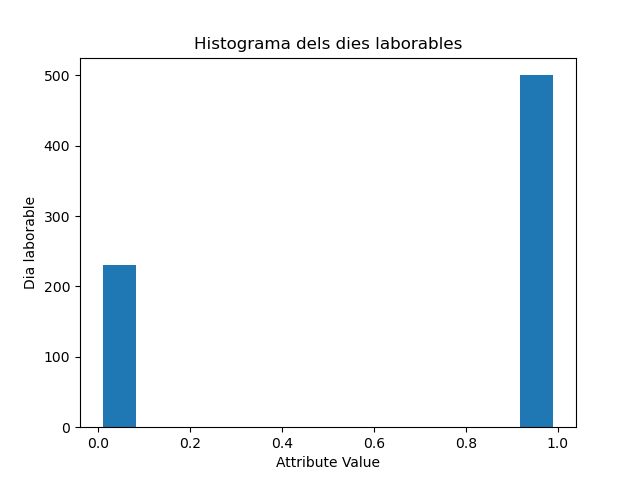

In [10]:
#Histograma de workingday

plt.figure()
plt.title("Histograma dels dies laborables")
plt.xlabel("Attribute Value")
plt.ylabel("Dia laborable")
hist = plt.hist(x[:,0], bins=11, range=[np.min(x[:,0]), np.max(x[:,0])], histtype="bar", rwidth=0.8)

Com és una variable binària no podem extreure molta informació: hi ha més dies laborables que no laborables.

<IPython.core.display.Javascript object>


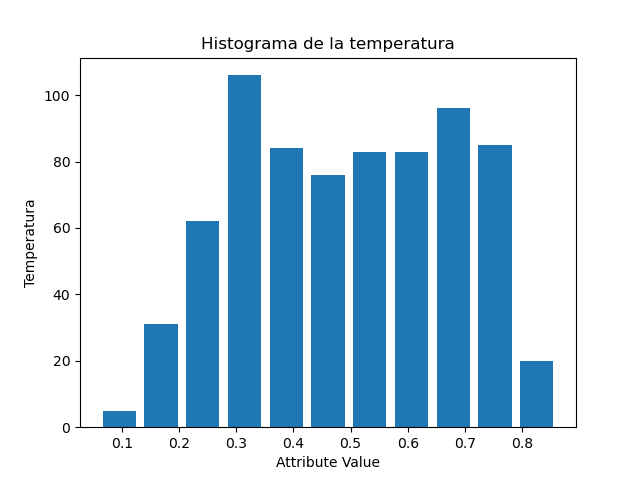

In [11]:
#Histograma amb temp

plt.figure()
plt.title("Histograma de la temperatura")
plt.xlabel("Attribute Value")
plt.ylabel("Temperatura")
hist = plt.hist(x[:,1], bins=11, range=[np.min(x[:,1]), np.max(x[:,1])], histtype="bar", rwidth=0.8)

Potser segueix una Normal, haurriem d'analitzar-ho amb més detall.

<IPython.core.display.Javascript object>


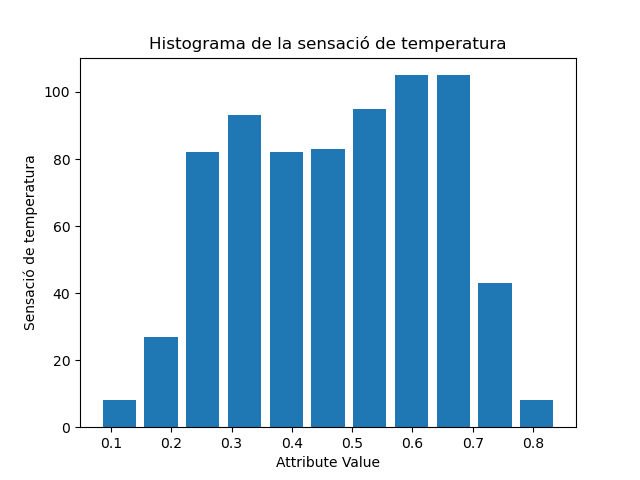

In [12]:
#Histograma amb atemp

plt.figure()
plt.title("Histograma de la sensació de temperatura")
plt.xlabel("Attribute Value")
plt.ylabel("Sensació de temperatura")
hist = plt.hist(x[:,2], bins=11, range=[np.min(x[:,2]), np.max(x[:,2])], histtype="bar", rwidth=0.8)

Potser té una distribució Normal, hauriem d'analitzar-ho amb més detall.

<IPython.core.display.Javascript object>


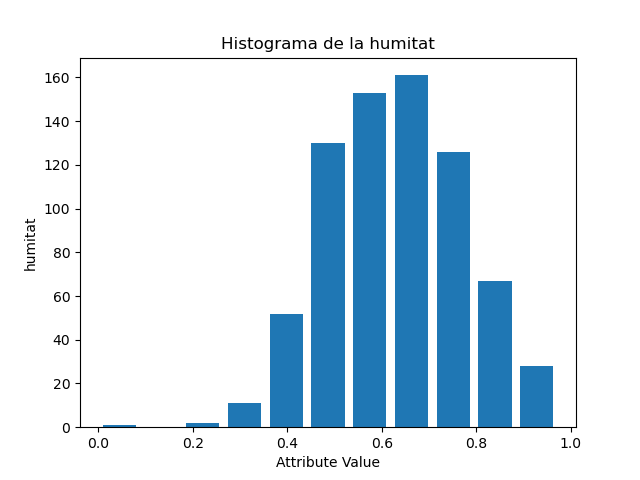

In [13]:
#Histograma amb hum

plt.figure()
plt.title("Histograma de la humitat")
plt.xlabel("Attribute Value")
plt.ylabel("humitat")
hist = plt.hist(x[:,3], bins=11, range=[np.min(x[:,3]), np.max(x[:,3])], histtype="bar", rwidth=0.8)

Potser segueix una Gaussiana, haurriem d'analitzar-ho amb més detall.

<IPython.core.display.Javascript object>


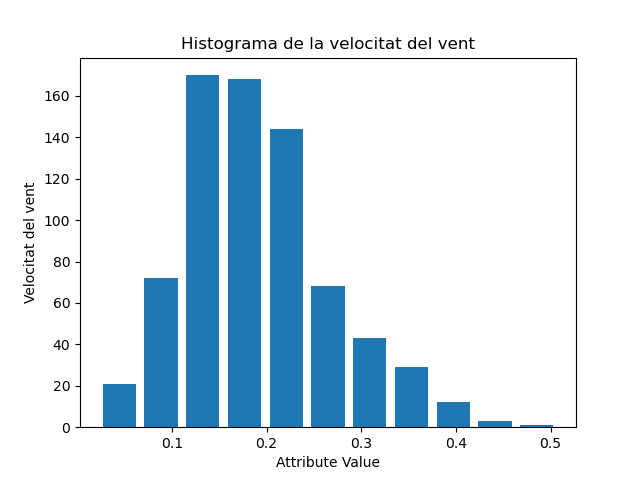

In [14]:
#Histograma amb windspeed
plt.figure()
plt.title("Histograma de la velocitat del vent")
plt.xlabel("Attribute Value")
plt.ylabel("Velocitat del vent")
hist = plt.hist(x[:,4], bins=11, range=[np.min(x[:,4]), np.max(x[:,4])], histtype="bar", rwidth=0.8)

Potser segueix una Normal, haurriem d'analitzar-ho amb més detall.

<IPython.core.display.Javascript object>


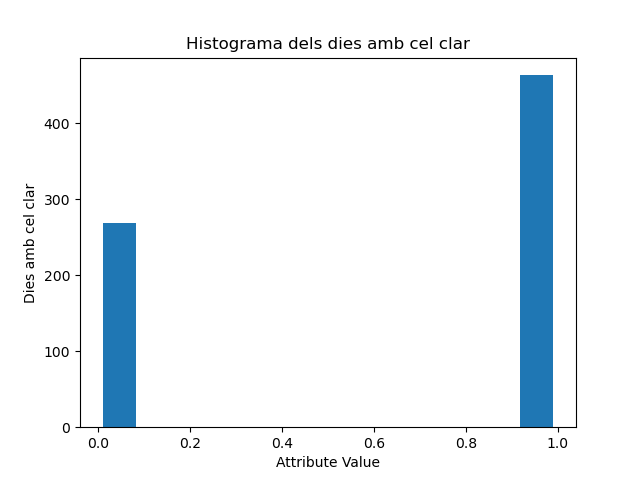

In [15]:
#Histograma amb Clear
plt.figure()
plt.title("Histograma dels dies amb cel clar")
plt.xlabel("Attribute Value")
plt.ylabel("Dies amb cel clar")
hist = plt.hist(x[:,5], bins=11, range=[np.min(x[:,5]), np.max(x[:,5])], histtype="bar", rwidth=0.8)

Com és una variable binària no podem extreure molta informació: hi ha més dies amb cel clar que no amb núvols.

<IPython.core.display.Javascript object>


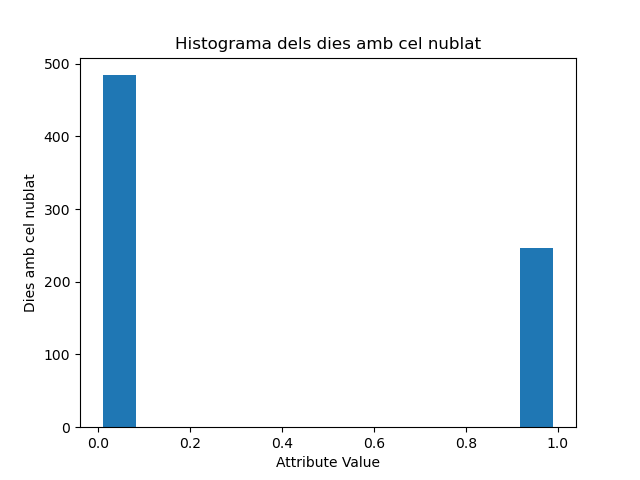

In [16]:
#Histograma amb Mist&Cloudy
plt.figure()
plt.title("Histograma dels dies amb cel nublat")
plt.xlabel("Attribute Value")
plt.ylabel("Dies amb cel nublat")
hist = plt.hist(x[:,6], bins=11, range=[np.min(x[:,6]), np.max(x[:,6])], histtype="bar", rwidth=0.8)

Com és una variable binària no podem extreure molta informació: hi ha més dies sense núvols que no amb el cel enovulat.

<IPython.core.display.Javascript object>


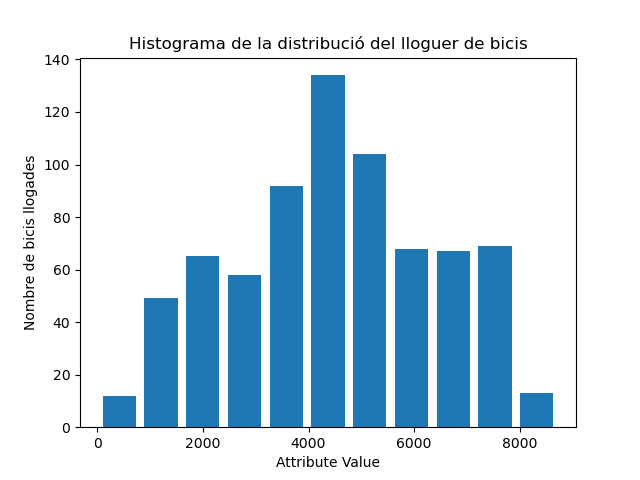

In [17]:
#Histograma amb cnt
plt.figure()
plt.title("Histograma de la distribució del lloguer de bicis")
plt.xlabel("Attribute Value")
plt.ylabel("Nombre de bicis llogades")
hist = plt.hist(y, bins=11, range=[np.min(y), np.max(y)], histtype="bar", rwidth=0.8)

Potser té una distribució Gaussiana, haurriem d'analitzar-ho amb més detall.

Per fer un analisi més profund d'aquelles variables possiblement Normals o Gaussianes hem realitzat dos tests de Normalitat: 


    - Shapiro-Wilk Normality Test
    - D'Agostino's K^2 Normality Test

## Tests fets amb Shapiro-Wilk

In [18]:
from scipy.stats import shapiro
data = dataset['temp']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.966, p=0.000
Probably not Gaussian


In [19]:
from scipy.stats import shapiro
data = dataset['atemp']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.974, p=0.000
Probably not Gaussian


In [20]:
from scipy.stats import shapiro
data = dataset['hum']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.993, p=0.002
Probably not Gaussian


In [21]:
from scipy.stats import shapiro
data = dataset['windspeed']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.971, p=0.000
Probably not Gaussian


In [22]:
from scipy.stats import shapiro
data = dataset['cnt2']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.980, p=0.000
Probably not Gaussian


## Tests fets amb Agostino's K^2

In [23]:
from scipy.stats import normaltest
data = dataset['temp']
stat, p = normaltest(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=294.297, p=0.000
Probably not Gaussian


In [24]:
from scipy.stats import normaltest
data = dataset['atemp']
stat, p = normaltest(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=144.352, p=0.000
Probably not Gaussian


In [25]:
from scipy.stats import normaltest
data = dataset['windspeed']
stat, p = normaltest(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=51.425, p=0.000
Probably not Gaussian


In [26]:
from scipy.stats import normaltest
data = dataset['hum']
stat, p = normaltest(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=0.683, p=0.711
Probably Gaussian


In [27]:
from scipy.stats import normaltest
data = dataset['cnt2']
stat, p = normaltest(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

stat=62.708, p=0.000
Probably not Gaussian


# Estudi del nostre dataset

Per veure les estadístiques del nostre dataset executem la comanda describe()

In [28]:
dataset.describe()

workingday    temp   atemp     hum  windspeed   Clear  Mist&Cloudy  \
count     731.000 731.000 731.000 731.000    731.000 731.000      731.000   
mean        0.684   0.495   0.474   0.628      0.190   0.633        0.338   
std         0.465   0.183   0.163   0.142      0.077   0.482        0.473   
min         0.000   0.059   0.079   0.000      0.022   0.000        0.000   
25%         0.000   0.337   0.338   0.520      0.135   0.000        0.000   
50%         1.000   0.498   0.487   0.627      0.181   1.000        0.000   
75%         1.000   0.655   0.609   0.730      0.233   1.000        1.000   
max         1.000   0.862   0.841   0.973      0.507   1.000        1.000   

          cnt2  
count  731.000  
mean  4504.349  
std   1937.211  
min     22.000  
25%   3152.000  
50%   4548.000  
75%   5956.000  
max   8714.000

Tenim y definida com la el nombre total de bicicletes llogades (cnt). Anem a dibuixar diferents histogrames amb les altres dades que tenim:

<IPython.core.display.Javascript object>


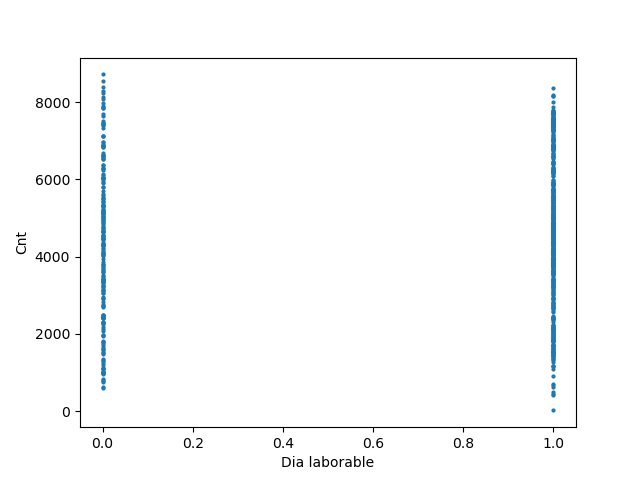

<function matplotlib.pyplot.show(block=None)>

In [29]:
#Scatter amb workingday

plt.figure()
plt.scatter(x[:,0], y, s=4)
plt.xlabel("Dia laborable")
plt.ylabel("Cnt")
plt.show

<IPython.core.display.Javascript object>


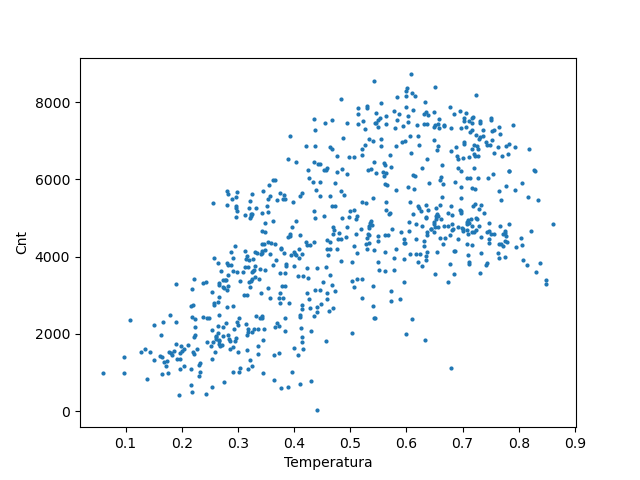

<function matplotlib.pyplot.show(block=None)>

In [30]:
#Scatter amb temp

plt.figure()
plt.scatter(x[:,1], y, s=4)
plt.xlabel("Temperatura")
plt.ylabel("Cnt")
plt.show

<IPython.core.display.Javascript object>


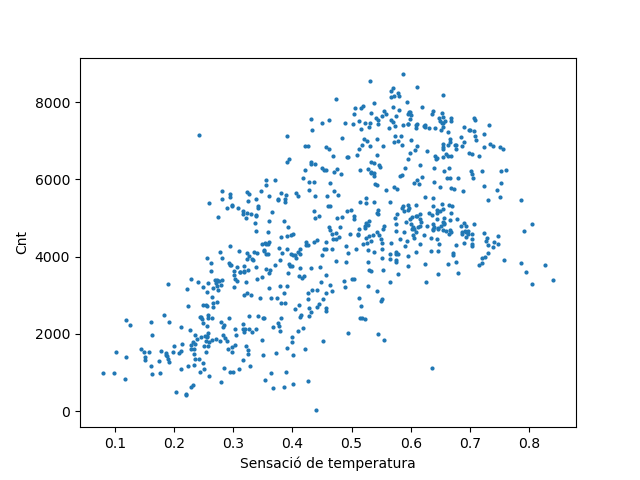

<function matplotlib.pyplot.show(block=None)>

In [31]:
#Scatter amb atemp

plt.figure()
plt.scatter(x[:,2], y, s=4)
plt.xlabel("Sensació de temperatura")
plt.ylabel("Cnt")
plt.show

<IPython.core.display.Javascript object>


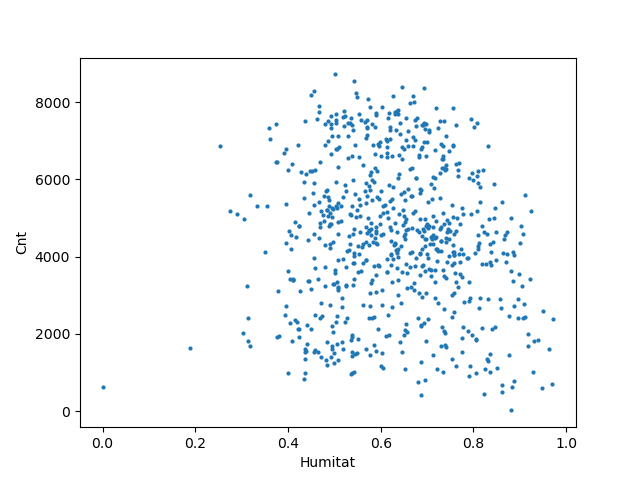

<function matplotlib.pyplot.show(block=None)>

In [32]:
#Scatter amb hum

plt.figure()
plt.scatter(x[:,3], y, s=4)
plt.xlabel("Humitat")
plt.ylabel("Cnt")
plt.show

<IPython.core.display.Javascript object>


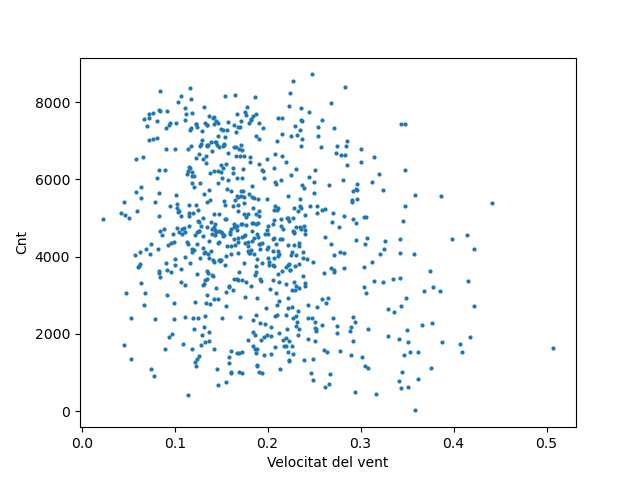

<function matplotlib.pyplot.show(block=None)>

In [33]:
#Scatter amb windspeed

plt.figure()
plt.scatter(x[:,4], y, s=4)
plt.xlabel("Velocitat del vent")
plt.ylabel("Cnt")
plt.show

<IPython.core.display.Javascript object>


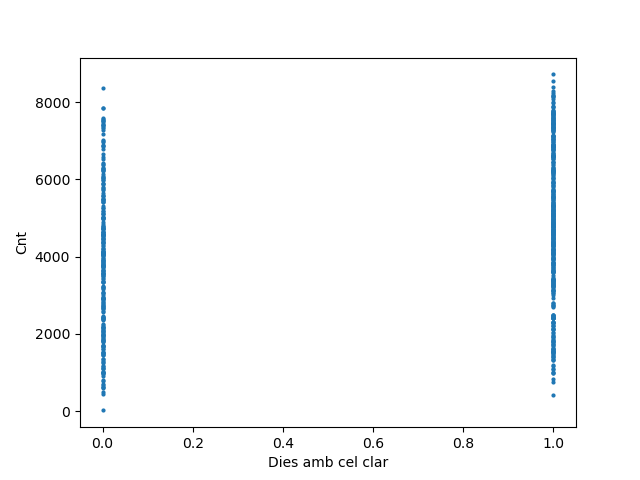

<function matplotlib.pyplot.show(block=None)>

In [34]:
#Scatter amb Clear

plt.figure()
plt.scatter(x[:,5], y, s=4)
plt.xlabel("Dies amb cel clar")
plt.ylabel("Cnt")
plt.show

<IPython.core.display.Javascript object>


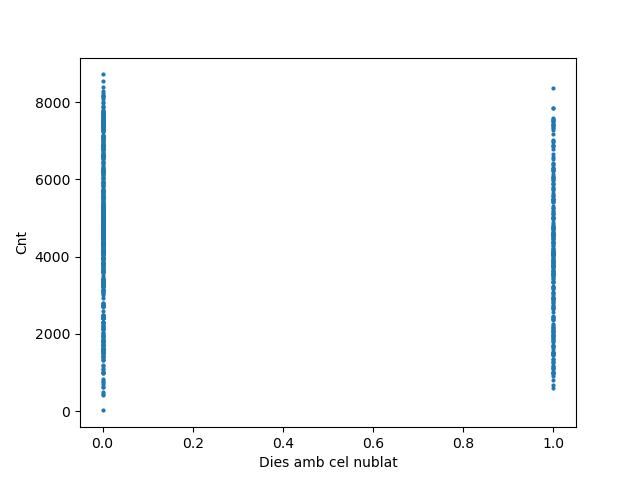

<function matplotlib.pyplot.show(block=None)>

In [35]:
#Scatter amb Mist&Cloudy

plt.figure()
plt.scatter(x[:,6], y, s=4)
plt.xlabel("Dies amb cel nublat")
plt.ylabel("Cnt")
plt.show

Els gràfics amb valors boleans s’identifiquen fàcilment perquè es tracta només de dues co-
lumnes sobre el 0 i l’1. Dels altres gràfics de dispersió podem veure si els punts segueixen una
tendència o no. Si ens fixem en la sensació de temperatura i la temperatura podem veure com
els punts tenen tendència a augmentar juntament amb el valor de la CNT. En canvi l’humitat i
la velocitat del vent tenen tots els punts concentrats a un únic punt i no mostren cap variació.

Una altra manera d'avaluar la relació entre els atributs és fent servir la comanda pairplot. Per poder distingir millor les dades, hem destacat els dies laborables.

<IPython.core.display.Javascript object>


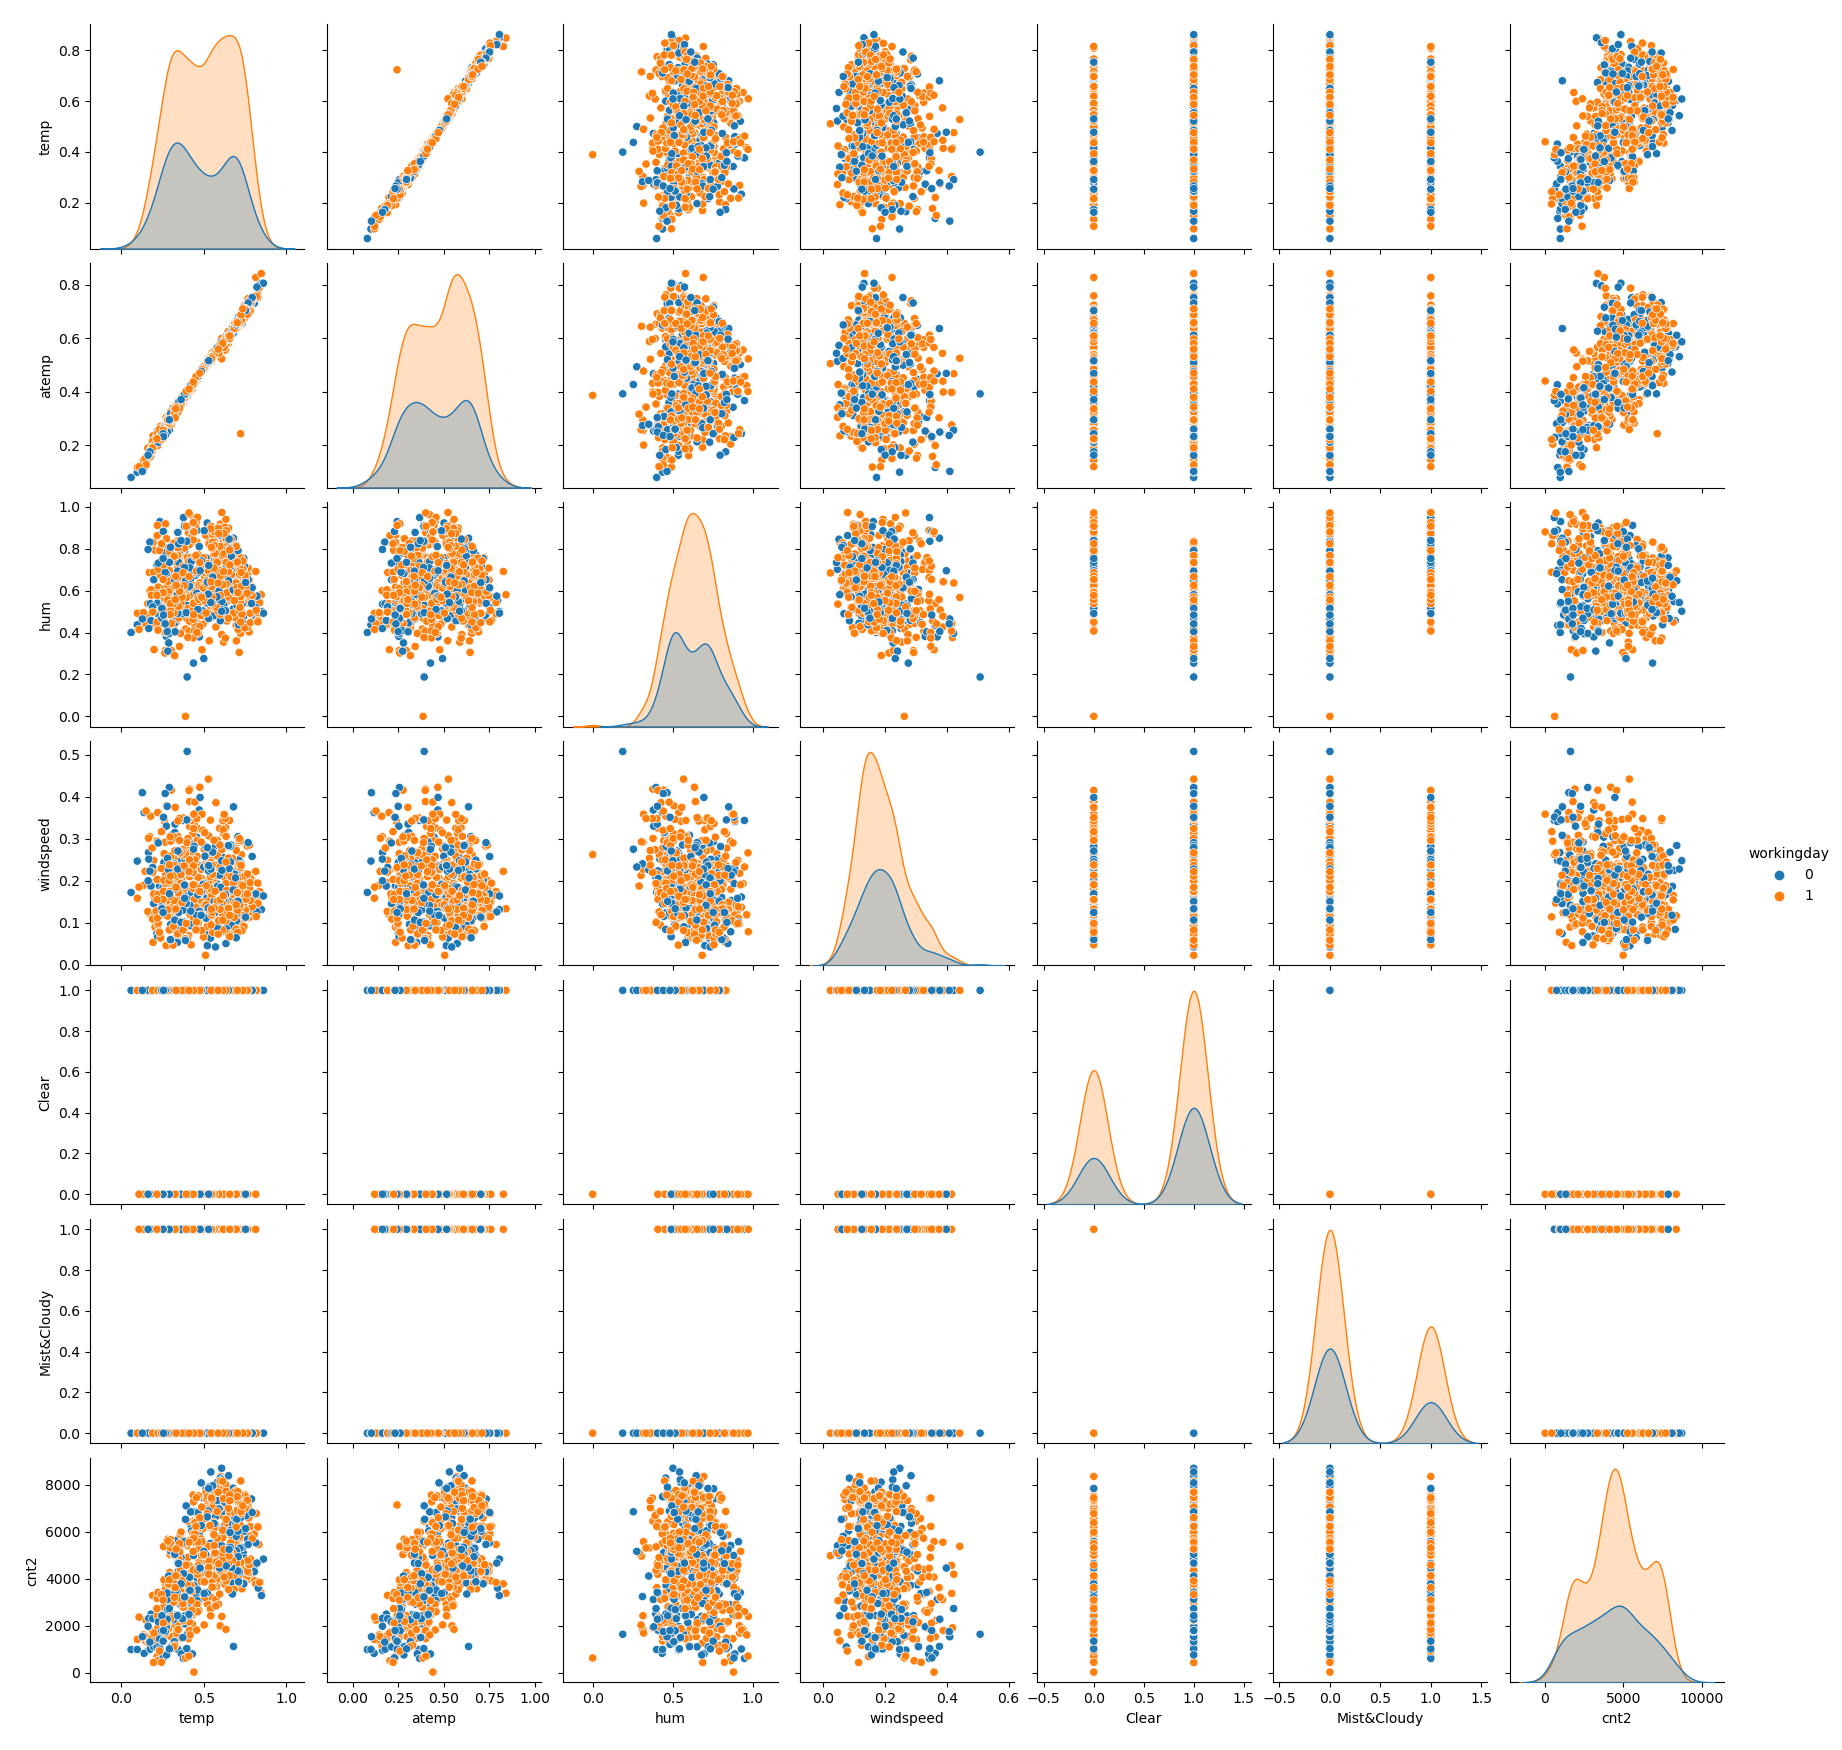

In [36]:
relacio = sns.pairplot(dataset, hue='workingday')

Hi ha molts més dies laborables que no laborables. Com que no som capaços de veure cap relació amb les gràfiques que tenim a continuació, intentem reduïr el nombre de dies laborables per a veure si som capaços de distinguir els punts amb més claredat. Per fer-ho, creem un dataset auxiliar (que només ens servirà per a veure aquest histograma) seleccionant el mateix nombre de dies laborables i dies no laborables. Els dies laborables seran escollits aleatòriament.

In [37]:
index = 0

list_index = []
random_index = []
drop_list = []

dataset_aux = dataset

for i in dataset.values:
    if i[0] == 1:
        list_index.append(index)
    
    index += 1

while len(random_index) < 269: #diferencia de dies laborables i dies no laborables (500 - 231 = 269)
    randint = random.randint(0,len(list_index)+1)
    
    if randint not in random_index:
        random_index.append(randint)

dataset_aux = dataset_aux.drop(random_index, axis=0)

dataset_aux

workingday  temp  atemp   hum  windspeed  Clear  Mist&Cloudy  cnt2
1             0 0.363  0.354 0.696      0.249      0            1   801
2             1 0.196  0.189 0.437      0.248      1            0  1349
5             1 0.204  0.233 0.518      0.090      1            0  1606
10            1 0.169  0.191 0.686      0.122      0            1  1263
11            1 0.173  0.160 0.600      0.305      1            0  1162
..          ...   ...    ...   ...        ...    ...          ...   ...
726           1 0.254  0.227 0.653      0.350      0            1  2114
727           1 0.253  0.255 0.590      0.155      0            1  3095
728           0 0.253  0.242 0.753      0.124      0            1  1341
729           0 0.256  0.232 0.483      0.351      1            0  1796
730           1 0.216  0.223 0.578      0.155      0            1  2729

[462 rows x 8 columns]

Un cop tenim la mateixa proporció de dies, intentem imprimir l'histograma una altra vegada

<IPython.core.display.Javascript object>


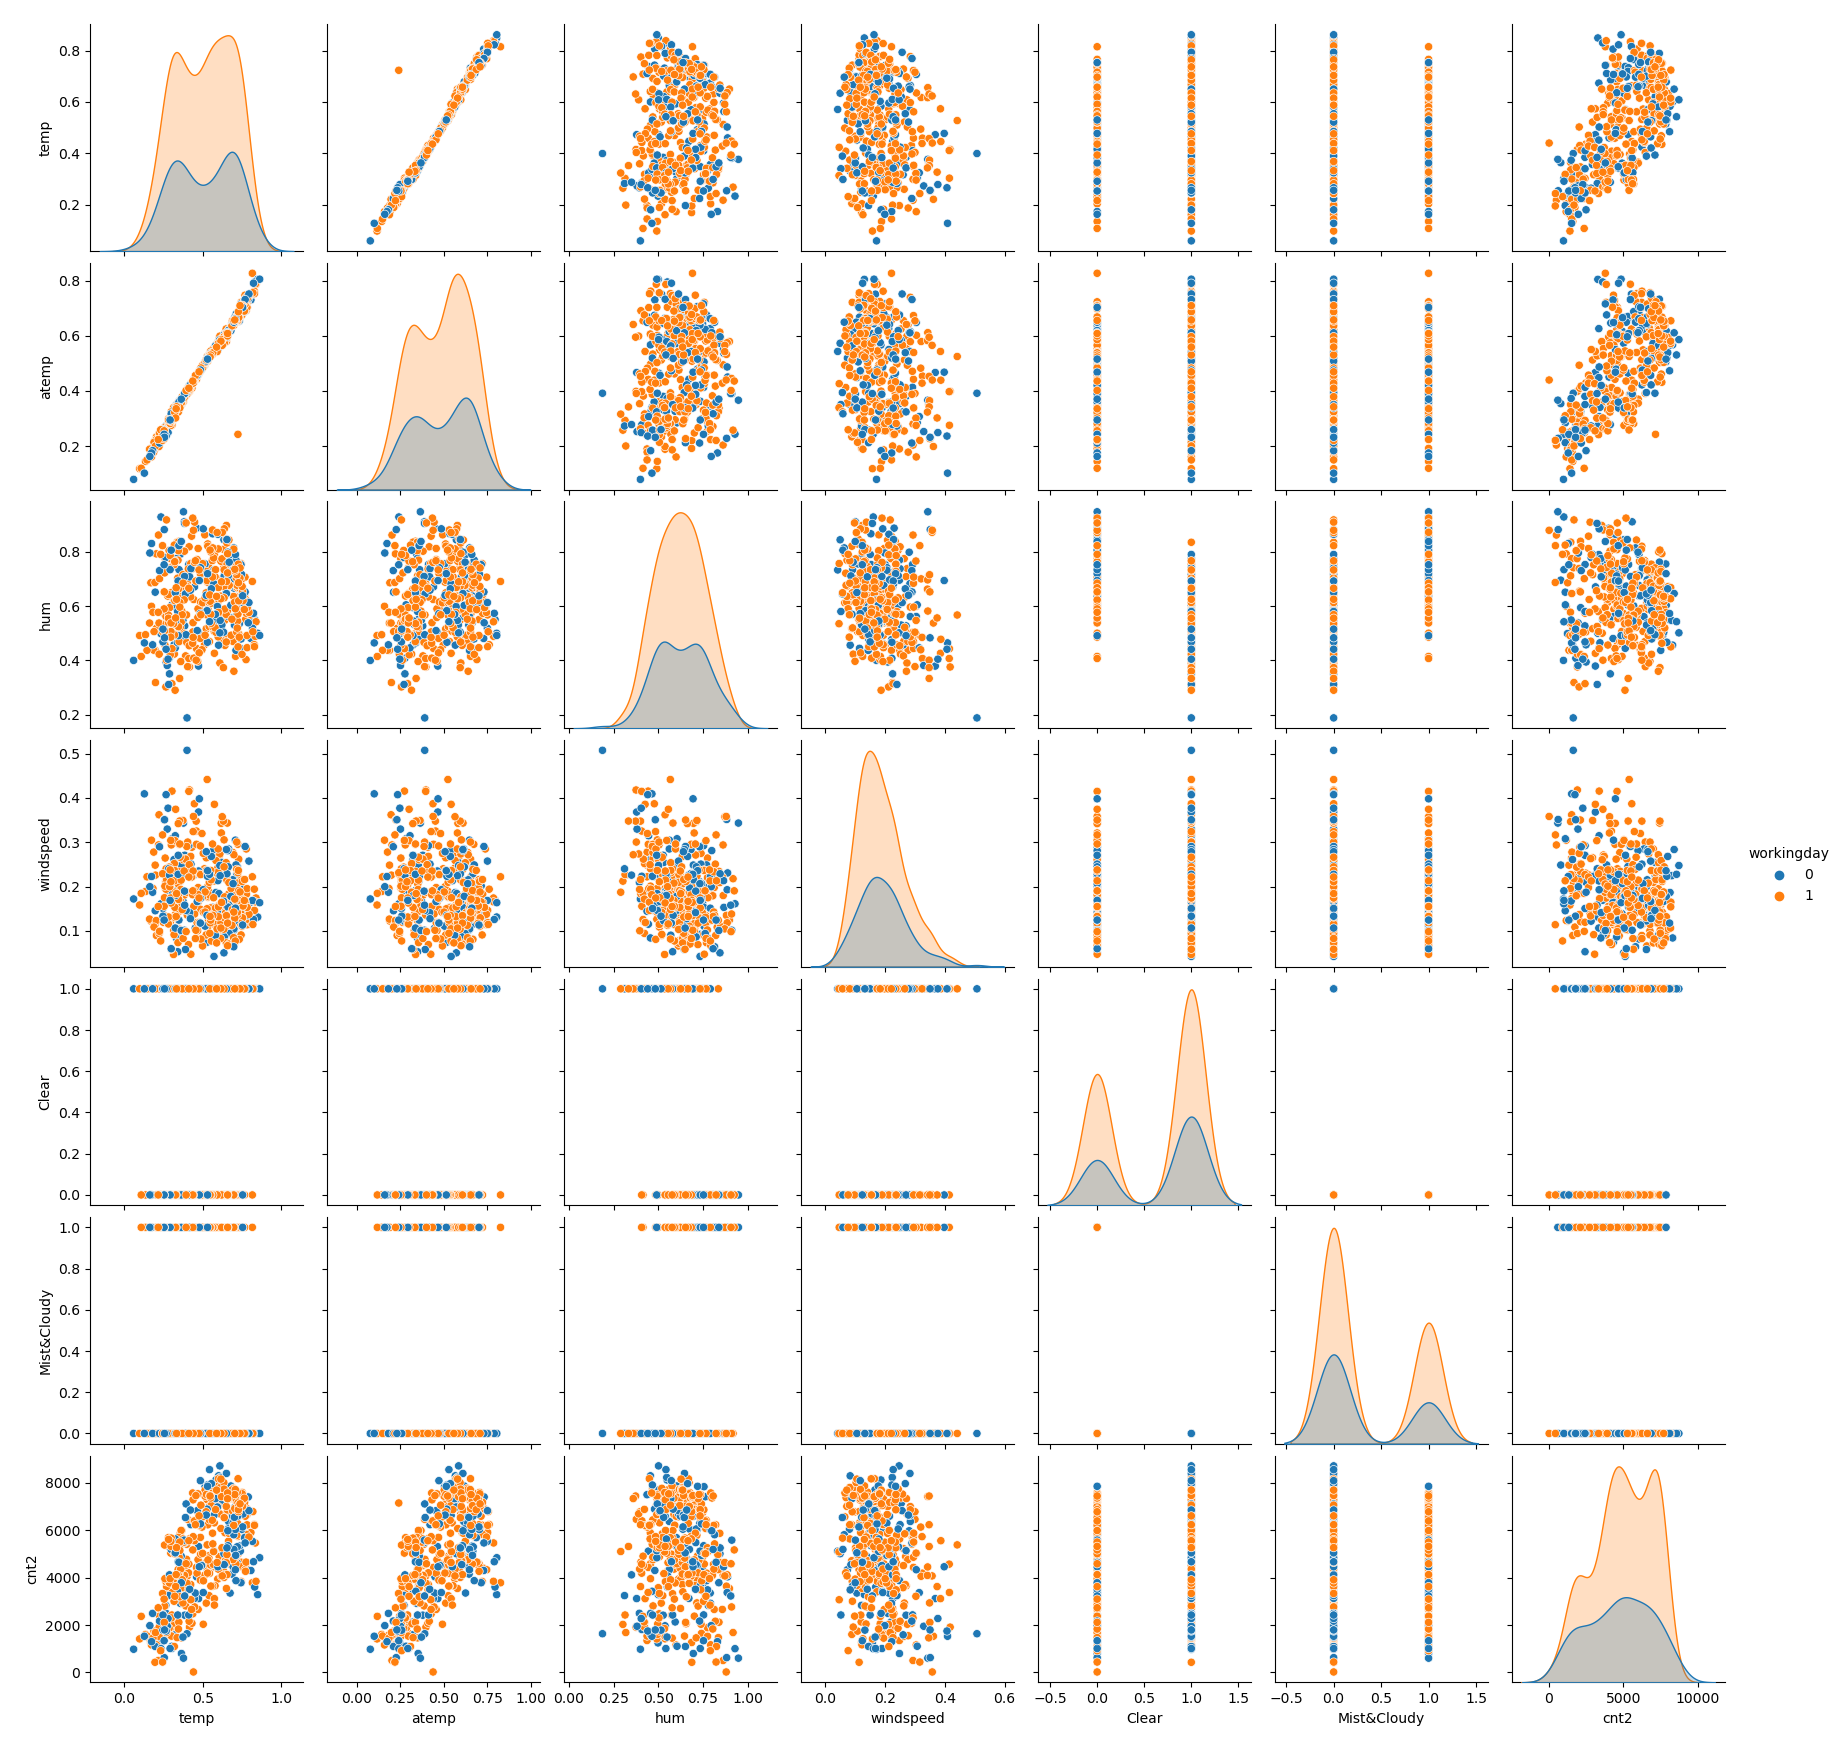

In [38]:
relacio = sns.pairplot(dataset_aux, hue='workingday')

Tot i haver reduït el nombre de dies laborables, tampoc som capaços d'extreure cap informació valuosa d'aquest histograma. Al continuació estudiarem la relació entre les variables de froma numérica.

Primer estudiarem la correlació amb totes les dades que tenim mitjançant la comanda heatmap

<IPython.core.display.Javascript object>


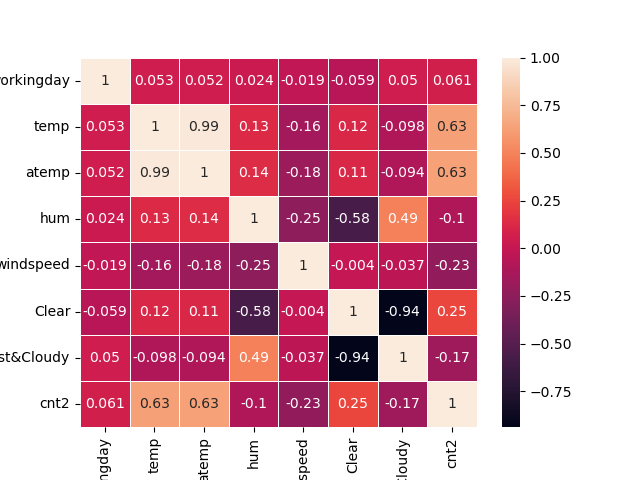

In [39]:
correlacio = dataset.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

A partir d'aquesta taula podem estudiar quins son els atributs que tenen més correlació entre ells. Podem destacar:

* Atemp i temp estan altament relacionades. La qual cosa té sentit, perquè com més alta és la temperatura, major és la sensació que fa calor o fred.
* Clear amb Mist&Cloudy. La qual cosa té sentit, doncs no pot ser que el cel estigui clar i nublat alhora.
* Cnt amb temp i atemp
* Hum amb Mist&Cloudy i Clear

Les variables workingday i windspeed no tenen una correlació elevada amb cap de les altres variables, per tant podem deduir que no són condicions que determinin la decisió d'agafar o no la bicicleta.

Una altra manera d'estudiar la correlació és mitjançant test de correlació de Pearson. El test de correlació de Pearson és una mesura de dependència lineal entre dos variables aleatòries quantitatives, i és independent de l'escala de la mesura de les variables. Donades dues variables aleatories $(X,Y)$

In [40]:
from scipy.stats import pearsonr
data1 = dataset['temp']
data2 = dataset['cnt2']
stat, p = pearsonr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=0.627, p=0.000
Probably dependent


In [41]:
from scipy.stats import pearsonr
data1 = dataset['atemp']
data2 = dataset['cnt2']
stat, p = pearsonr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=0.631, p=0.000
Probably dependent


In [42]:
from scipy.stats import pearsonr
data1 = dataset['hum']
data2 = dataset['cnt2']
stat, p = pearsonr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=-0.101, p=0.006
Probably dependent


In [43]:
from scipy.stats import pearsonr
data1 = dataset['windspeed']
data2 = dataset['cnt2']
stat, p = pearsonr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=-0.235, p=0.000
Probably dependent


# Regressions lineals del nostre model

Per poder fer les regressions lineals del nostre model, primer ens cal definir algunes funcions que ens permetran fer el càlcul corresponent. Aquestes funcions són les següents.

In [44]:
def mean_squeared_error(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

In [45]:
def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

In [46]:
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

In [47]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]

Un cop tenim aquestes funcions, el que hem de fer és definir les nostres x i les nostres y. A partir de les correlacions que hem trobat anteriorment, hem arribat a la conclusió que el que està més relacionat a l'hora de determinar si es lloga o no una bicicleta és la sensació de la temperatura que hi ha a l'exterior. És per això que les nostres x serà la variable atemp i les nostres y seran la cnt.

Anem a fer una predicció del nostre model

<IPython.core.display.Javascript object>


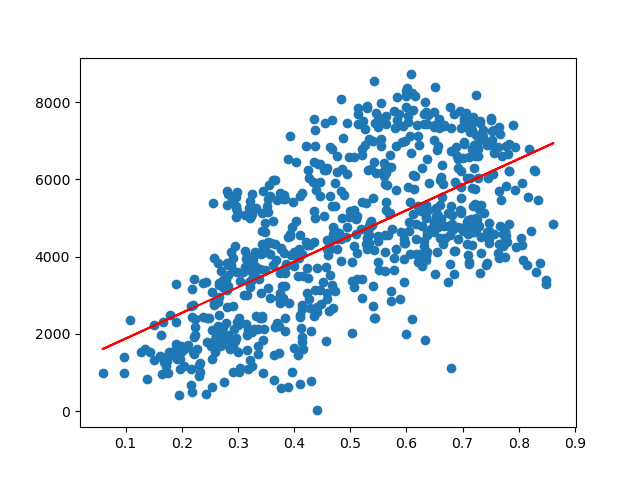

Mean squeared error:  2272020.2556456523
R2 score:  0.3937487313729242


In [48]:
# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
atribut1 = x[:,1].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,1], y)
plt.plot(atribut1[:,0], predicted, 'r')

# Mostrem l'error (MSE i R2)
MSE = mean_squeared_error(y, predicted)
r2 = r2_score(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

Si ens fixem amb el valor de l'MSE podem veure que és del valor de $2\cdot10^6$. això s'explica observant l'eix de les y, ja que es divideix en intervals de 2000 unitats. Hi ha punts doncs que es troben a més de 2000 unitats de distancia respecte la recta de regressió vermella. Aquest valor elevat al quadrat ens dona nombres del valor de $10^6$, i fent el sumatori de les diferencies, amb la regressió que tenim és normal obtenir un MSE tan gran

A vegades estandaritzar o normalitzar les dades pot afectar en el un model de regressió lineal. Com que no sabem si les nostres dades seran sensibles a l'estandarització n'hem a probar-ho amb una altre x

In [49]:
x_t = standarize(x)

<IPython.core.display.Javascript object>


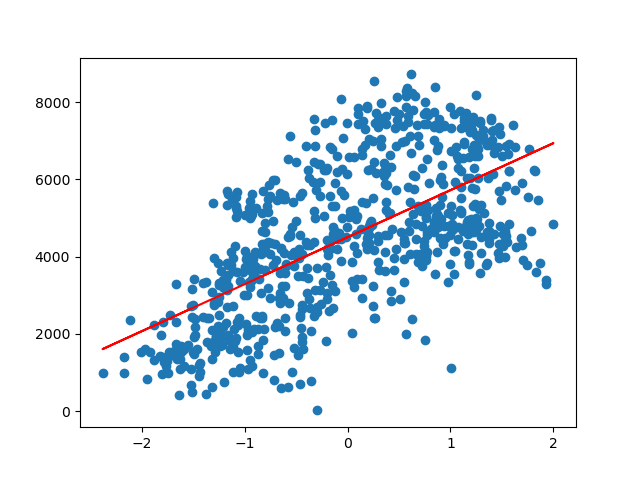

Mean squeared error:  2272020.2556456523
R2 score:  0.3937487313729242


In [50]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
atribut1 = x_t[:,1].reshape(x_t.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x_t[:,1], y)
plt.plot(atribut1[:,0], predicted, 'r')

# Mostrem l'error (MSE i R2)
MSE = mean_squeared_error(y, predicted)
r2 = r2_score(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

Els resultats continuen sense cambiar. Ara mirem si el dataset es sensible a la normalització.

C:\Users\marcb\AppData\Local\Temp\ipykernel_22388\2111041159.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


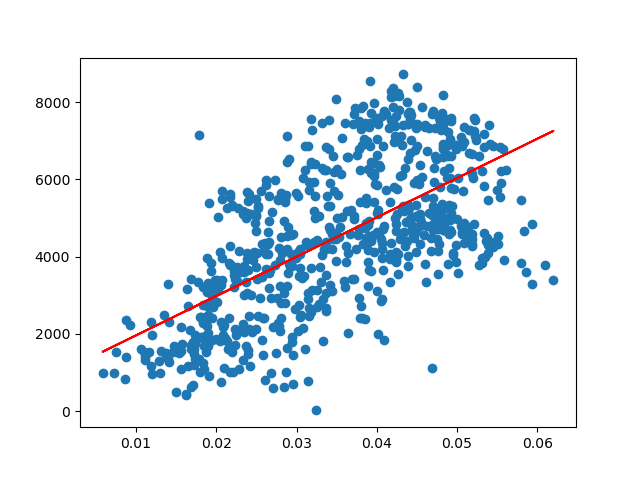

Mean squeared error:  2255173.8513220353
R2 score:  0.39824391752613697


In [51]:
normalized_arr = preprocessing.normalize([dataset['atemp']])

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
atribut1 = normalized_arr.reshape(normalized_arr.shape[1], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(normalized_arr, y)
plt.plot(atribut1[:,0], predicted, 'r')

# Mostrem l'error (MSE i R2)
MSE = mean_squeared_error(y, predicted)
r2 = r2_score(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

Tampoc ha hagut cap diferencia.

En tots tres casos veiem com el valor de l'MSE continua sent molt gran i el valor de l'$R^2$ també.

Arribats a aquest punt ens preguntem què passaria si calculem els valors de R2 i de l’MSE a
partir d’una regressió polinòmica de diferents graus. Intentem aplicar una regressió polinòmica per mirar si som capaços de reduïr el valor del nostre MSE i augmentar el valor de $R^2$.

In [52]:
mymodel = np.poly1d(np.polyfit(x[:,1], y, 16)) #a partir de 17 sale un error de memoria xd

print(r2_score(y, mymodel(x[:,1])))
print(mean_squeared_error(y, mymodel(x[:,1])))

0.47619873766992304
1963026.1238739889


Veiem com amb un polinomi de grau 16 el valor de l'MSE disminueix al voltant de $3·10^5$ unitats, però continua sent molt gran i l'$R^2$ és massa baixa

In [53]:
listR = []
listMSE = []
listx = []

for i in range(1,16):
    mymodel = np.poly1d(np.polyfit(x[:,1], y, i))
    
    r2 = r2_score(y, mymodel(x[:,1]))
    mse = mean_squeared_error(y, mymodel(x[:,1]))
    
    listR.append([r2])
    listMSE.append([mse])
    listx.append(i)

<IPython.core.display.Javascript object>


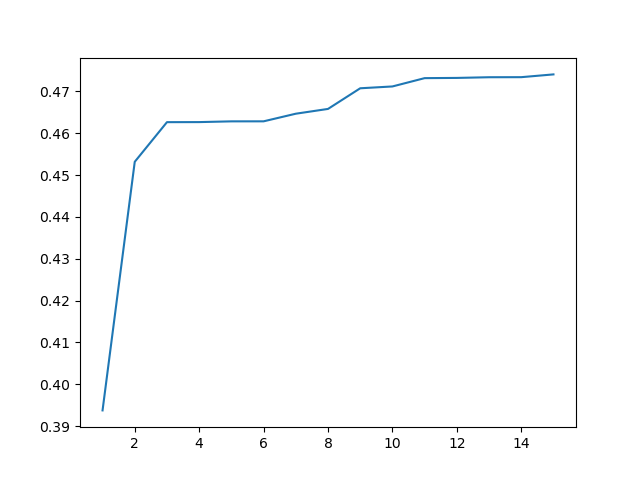

In [54]:
plt.figure()
plt.plot(listx, listR)
plt.show()

<IPython.core.display.Javascript object>


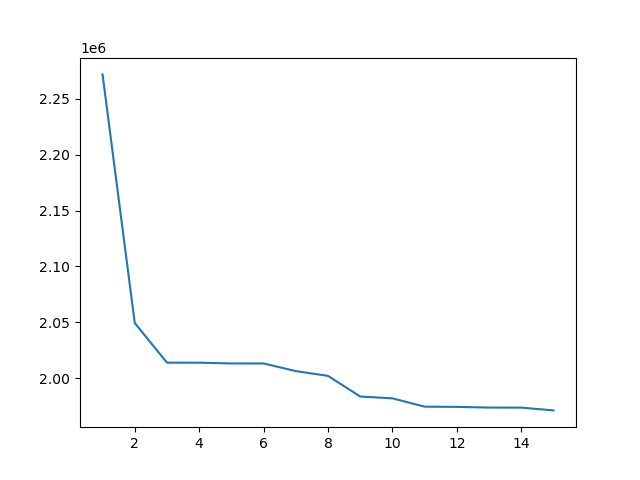

In [55]:
plt.figure()
plt.plot(listx, listMSE)
plt.show()

# Normalidad de los errores

In [68]:
data = dataset.values
x = data[:, :7]
y = data[:, 7]

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
atribut1 = x[:,0].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 

#Fem la predicció amb les dades originals, sense normalzar ni estandaritzar
predicted = regr.predict(atribut1)

# Mostrem l'error (MSE i R2)
MSE = mean_squeared_error(y, predicted)
r2 = r2_score(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

#Calculem els errors residuals
res = y - predicted
dataset['res'] = res

# Shapiro-Wilk Normality Test per a veure la dsitribució dels errors residuals

data = dataset['res']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')
    
dataset = dataset.drop(['res'], axis=1)

Mean squeared error:  3733637.9674631804
R2 score:  0.0037400640490624637
stat=0.981, p=0.000
Probably not Gaussian


# Comparem el MSE amb diferents atributs

In [57]:
print(dataset)

     workingday  temp  atemp   hum  windspeed  Clear  Mist&Cloudy  cnt2
0             0 0.344  0.364 0.806      0.160      0            1   985
1             0 0.363  0.354 0.696      0.249      0            1   801
2             1 0.196  0.189 0.437      0.248      1            0  1349
3             1 0.200  0.212 0.590      0.160      1            0  1562
4             1 0.227  0.229 0.437      0.187      1            0  1600
..          ...   ...    ...   ...        ...    ...          ...   ...
726           1 0.254  0.227 0.653      0.350      0            1  2114
727           1 0.253  0.255 0.590      0.155      0            1  3095
728           0 0.253  0.242 0.753      0.124      0            1  1341
729           0 0.256  0.232 0.483      0.351      1            0  1796
730           1 0.216  0.223 0.578      0.155      0            1  2729

[731 rows x 8 columns]


Amb workingday 

<IPython.core.display.Javascript object>


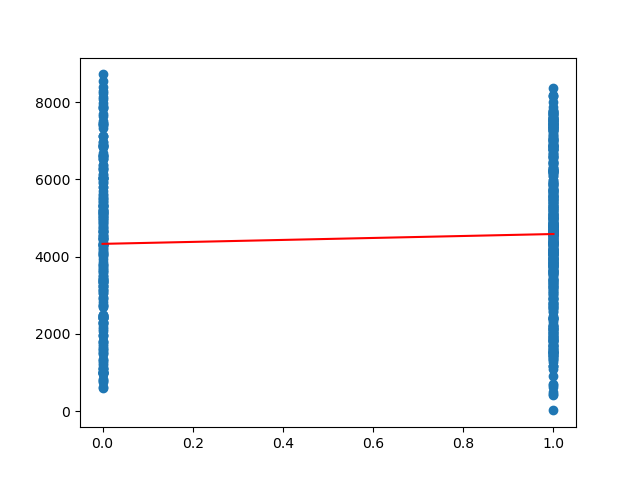

Mean squeared error:  3733637.9674631804
R2 score:  0.0037400640490624637


In [58]:
# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
atribut1 = x[:,0].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,0], y)
plt.plot(atribut1[:,0], predicted, 'r')

# Mostrem l'error (MSE i R2)
MSE = mean_squeared_error(y, predicted)
r2 = r2_score(y, predicted)


print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

Amb temp

<IPython.core.display.Javascript object>


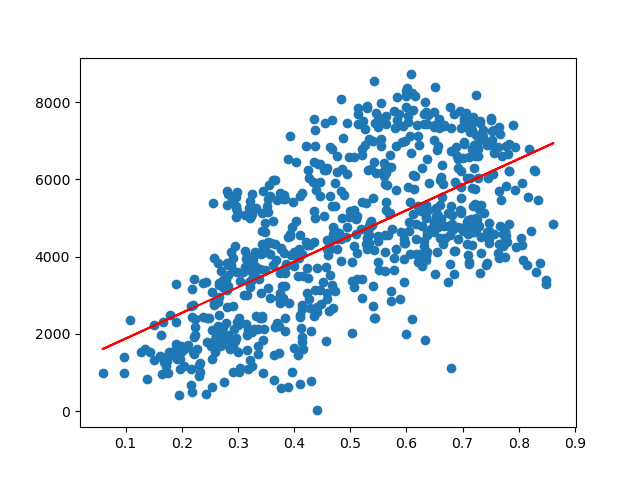

Mean squeared error:  2272020.2556456523
R2 score:  0.3937487313729242


In [59]:
# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
atribut1 = x[:,1].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,1], y)
plt.plot(atribut1[:,0], predicted, 'r')

# Mostrem l'error (MSE i R2)
MSE = mean_squeared_error(y, predicted)
r2 = r2_score(y, predicted)


print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

Amb atemp

<IPython.core.display.Javascript object>


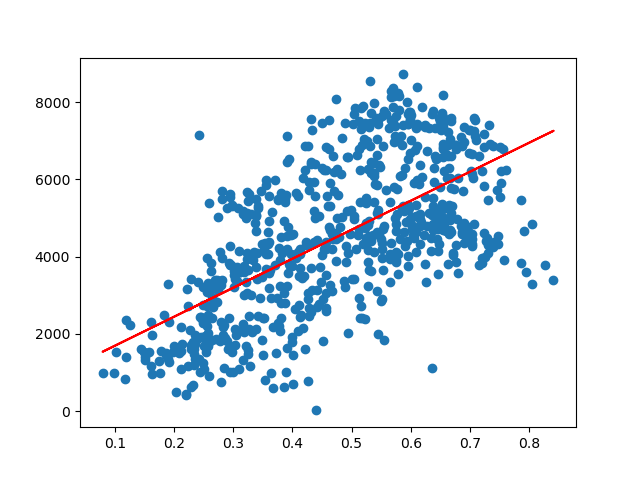

Mean squeared error:  2255173.8513220353
R2 score:  0.39824391752613697


In [60]:
# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
atribut1 = x[:,2].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,2], y)
plt.plot(atribut1[:,0], predicted, 'r')

# Mostrem l'error (MSE i R2)
MSE = mean_squeared_error(y, predicted)
r2 = r2_score(y, predicted)


print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

Amb hum

<IPython.core.display.Javascript object>


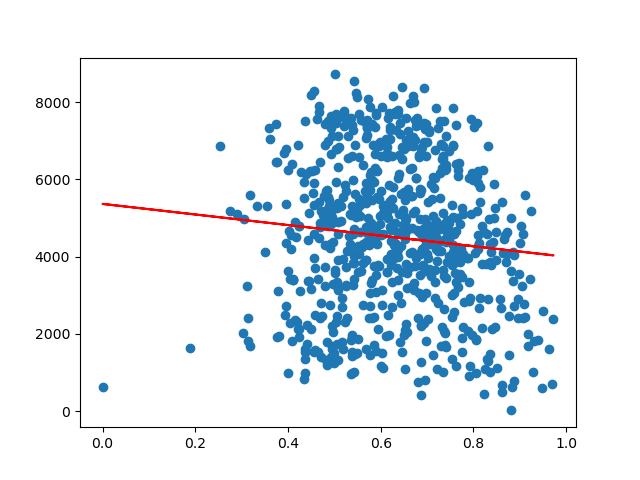

Mean squeared error:  3709682.652697436
R2 score:  0.010132146131519582


In [61]:
# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
atribut1 = x[:,3].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,3], y)
plt.plot(atribut1[:,0], predicted, 'r')

# Mostrem l'error (MSE i R2)
MSE = mean_squeared_error(y, predicted)
r2 = r2_score(y, predicted)


print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

Amb Windspeed

<IPython.core.display.Javascript object>


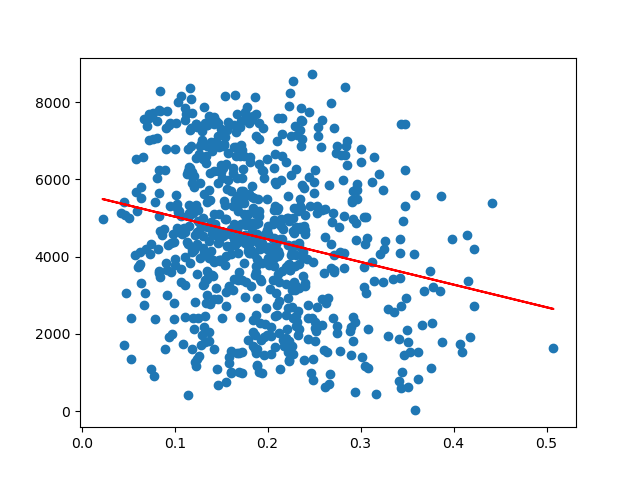

Mean squeared error:  3541490.883482077
R2 score:  0.05501135581553118


In [62]:
# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
atribut1 = x[:,4].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,4], y)
plt.plot(atribut1[:,0], predicted, 'r')

# Mostrem l'error (MSE i R2)
MSE = mean_squeared_error(y, predicted)
r2 = r2_score(y, predicted)


print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

Amb Clear

<IPython.core.display.Javascript object>


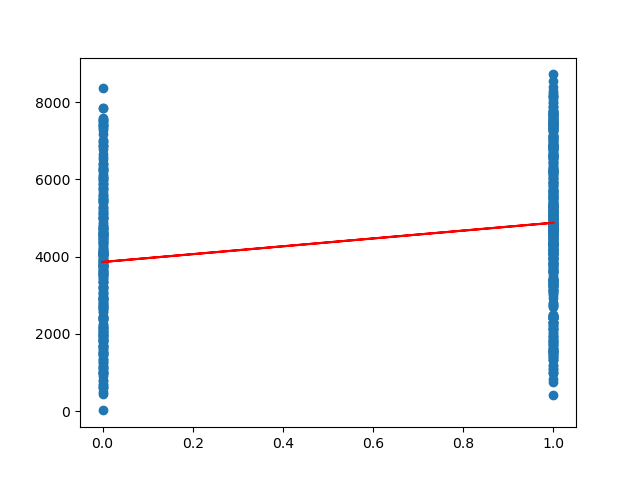

Mean squeared error:  3508018.1220054883
R2 score:  0.06394301215055309


In [63]:
# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
atribut1 = x[:,5].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,5], y)
plt.plot(atribut1[:,0], predicted, 'r')

# Mostrem l'error (MSE i R2)
MSE = mean_squeared_error(y, predicted)
r2 = r2_score(y, predicted)


print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

Amb Mist&Cloudy

<IPython.core.display.Javascript object>


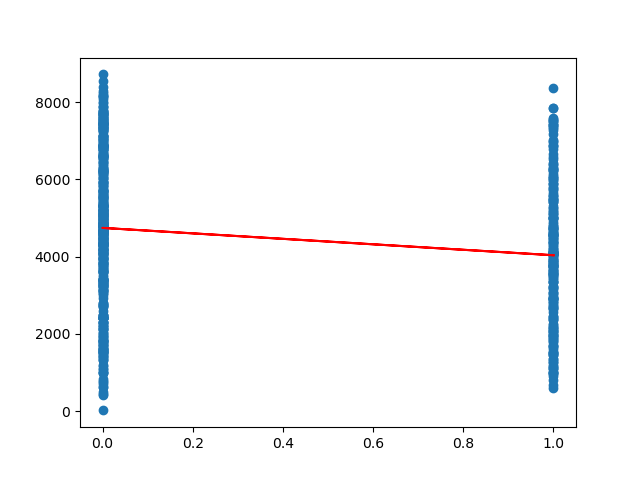

Mean squeared error:  3635647.2887412277
R2 score:  0.02988726636435568


In [64]:
# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
atribut1 = x[:,6].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,6], y)
plt.plot(atribut1[:,0], predicted, 'r')

# Mostrem l'error (MSE i R2)
MSE = mean_squeared_error(y, predicted)
r2 = r2_score(y, predicted)


print("Mean squeared error: ", MSE)
print("R2 score: ", r2)

## PCA

In [65]:
dataset_aux2 = dataset.drop(['cnt2'], axis=1)
print(dataset_aux2)

     workingday  temp  atemp   hum  windspeed  Clear  Mist&Cloudy
0             0 0.344  0.364 0.806      0.160      0            1
1             0 0.363  0.354 0.696      0.249      0            1
2             1 0.196  0.189 0.437      0.248      1            0
3             1 0.200  0.212 0.590      0.160      1            0
4             1 0.227  0.229 0.437      0.187      1            0
..          ...   ...    ...   ...        ...    ...          ...
726           1 0.254  0.227 0.653      0.350      0            1
727           1 0.253  0.255 0.590      0.155      0            1
728           0 0.253  0.242 0.753      0.124      0            1
729           0 0.256  0.232 0.483      0.351      1            0
730           1 0.216  0.223 0.578      0.155      0            1

[731 rows x 7 columns]


En el nostre dataset actual hi tenim 8 variables, per tant, necessitarem 8 components.

In [66]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(dataset_aux2)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']
print(modelo_pca.components_)

# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = dataset_aux2.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']
)

[[ 4.63664336e-02 -1.42024387e-01 -1.37705584e-01  4.54955088e-01
  -6.20658986e-02 -6.20306913e-01  6.02577318e-01]
 [-7.59144386e-02 -6.52219362e-01 -6.57090117e-01 -2.55551155e-01
   2.62257859e-01  3.50037809e-02 -4.20551779e-02]
 [-8.79945909e-01 -6.94915658e-02 -5.61439633e-02  1.62908888e-01
  -4.27917255e-01  6.84057388e-02 -5.81562291e-02]
 [-4.63480772e-01  2.14050107e-01  1.91602563e-01 -1.24715047e-01
   8.00904968e-01 -1.56894018e-01  1.45045646e-01]
 [-5.34757918e-02  8.19536401e-02  8.01002485e-02 -8.19289904e-01
  -3.15284529e-01 -2.10458374e-01  4.11187162e-01]
 [-1.04028401e-02  3.24566900e-02 -3.54674780e-03 -1.19508213e-01
  -5.60892384e-02 -7.34848044e-01 -6.64376325e-01]
 [-2.10474615e-04  7.04288730e-01 -7.09209020e-01  9.90786827e-03
  -1.60111413e-02  2.01150497e-02  1.55167062e-02]]


workingday   temp  atemp    hum  windspeed  Clear  Mist&Cloudy
PC1       0.046 -0.142 -0.138  0.455     -0.062 -0.620        0.603
PC2      -0.076 -0.652 -0.657 -0.256      0.262  0.035       -0.042
PC3      -0.880 -0.069 -0.056  0.163     -0.428  0.068       -0.058
PC4      -0.463  0.214  0.192 -0.125      0.801 -0.157        0.145
PC5      -0.053  0.082  0.080 -0.819     -0.315 -0.210        0.411
PC6      -0.010  0.032 -0.004 -0.120     -0.056 -0.735       -0.664
PC7      -0.000  0.704 -0.709  0.010     -0.016  0.020        0.016

----------------------------------------------------
Percentatge de variància explicada per cada component
----------------------------------------------------
[0.34145844 0.30085172 0.14310773 0.13677542 0.0692781  0.00740084
 0.00112776]


<IPython.core.display.Javascript object>


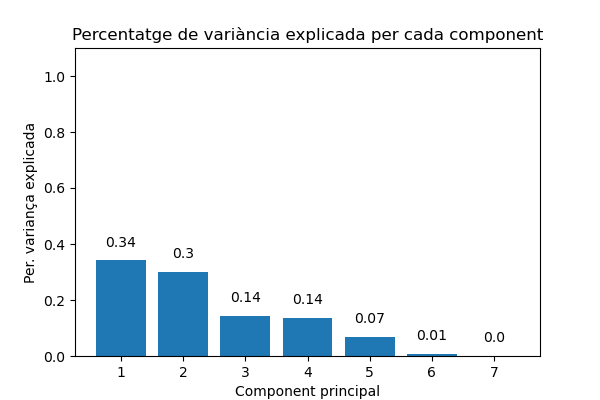

In [67]:
# Percentatge de variància explicada per cada component
# ==============================================================================
print('----------------------------------------------------')
print('Percentatge de variància explicada per cada component')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(dataset.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Percentatge de variància explicada per cada component')
ax.set_xlabel('Component principal')
ax.set_ylabel('Per. variança explicada');

En el nostre cas, la primer component explica el 34% de la variança observada en les dades i la segona el 30%. Les dues següents components expliquen un 14% i 14% respesctivament. Mentre que la resta no superen per separat l'1% de variància explicada.